## **☁️ Weather Forecasting Project**
This project is all about **predicting the weather** using real data and machine learning. I used historical weather records and applied data science techniques to build models that can forecast temperature, humidity, and other weather metrics.

Whether it’s helping farmers plan their crops or just deciding whether to carry an umbrella, **weather forecasting** has real impact — and this project shows how data science can help.

---

### **🚀 What I Did**

* 📊 **Collected & cleaned** historical weather data
* 🔍 **Explored patterns** in temperature, humidity, wind, etc.
* 🧠 **Built models** using regression and/or time-series techniques
* 📈 **Visualized results** with clean and informative charts
* 🧰 **Used tools** like Python, Pandas, Matplotlib, and Scikit-learn

> This project is designed to be clear, practical, and easy to follow for anyone interested in data science.

---

### **📌 Goals**

* Understand how to **work with real-world time-series data**
* Practice **data preprocessing, feature engineering, and modeling**
* Improve skills in **visualization and storytelling with data**
* Share a clear, well-documented project on GitHub

In [1]:
# ======================= Standard Libraries ==========================
import warnings
from datetime import datetime, timedelta
import requests

# ======================= Core Data Science ===========================
import numpy as np
import pandas as pd

# ======================= Visualization ===============================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ======================= Scikit-learn ================================
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

# ======================= XGBoost =====================================
from xgboost import XGBClassifier, XGBRegressor

# ======================= Time Series Analysis ==========================
from statsmodels.tsa.seasonal import seasonal_decompose

# ======================= Deep Learning ===============================


# ======================= Configuration ===============================
warnings.filterwarnings("ignore", category=UserWarning)
np.random.seed(42)

print("✅ All libraries imported successfully.")

✅ All libraries imported successfully.


<h1 align="center"> <strong>Data Collection</strong> </h1>

In [2]:
class WeatherAPI:
    def __init__(self):
        self.base_url      = "https://api.open-meteo.com/v1"
        self.geocoding_url = "https://geocoding-api.open-meteo.com/v1/search"
    
    # Get latitude and longitude for a city name
    def get_coordinates(self, city_name, country=None):
        params = {'name':city_name, 'count':5, 'language':'en', 'format':'json'}
        if country:
            params['country'] = country
        try:
            response = requests.get(self.geocoding_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if 'results' in data and len(data['results']) > 0:
                result = data['results'][0]
                return {
                    'name'      : result['name'],
                    'country'   : result.get('country', ''),
                    'admin1'    : result.get('admin1', ''),
                    'latitude'  : result['latitude'],
                    'longitude' : result['longitude']
                }
            else:
                raise ValueError(f"City '{city_name}' not found")
                
        except requests.exceptions.RequestException as e:
            raise Exception(f"Error fetching coordinates: {e}")
    ################################################################
    # Get historical weather data for a city
    def get_historical_weather(self, city_name, country=None, start_date=(datetime.now() - timedelta(days=(datetime.now().weekday() + 2) % 7)).strftime('%Y-%m-%d'), 
                    end_date=(datetime.now() + timedelta(days=(4 - datetime.now().weekday()) % 7)).strftime('%Y-%m-%d'), daily_params=None, hourly_params=None, save=None):
        
        # Default parameters if not specified
        if daily_params is None:
            daily_params = [
                'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
                'precipitation_sum', 'rain_sum', 'snowfall_sum',
                'precipitation_hours', 'windspeed_10m_max', 'winddirection_10m_dominant'
            ]
        
        if hourly_params is None:
            hourly_params = [
                'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
                'apparent_temperature', 'precipitation', 'rain', 'snowfall',
                'cloudcover', 'windspeed_10m', 'winddirection_10m'
            ]
        
        # Get coordinates for the city
        coords = self.get_coordinates(city_name, country)
        
        # Check if date is recent (use forecast API) or historical
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        today    = datetime.now()
        days_ago = (today - start_dt).days
        
        # ----- Determine which endpoint to use ----- 
        if days_ago <= 5:
            # Use forecast API for recent/current data
            endpoint = f"{self.base_url}/forecast"
        else:
            # Use historical weather API
            endpoint = "https://historical-forecast-api.open-meteo.com/v1/forecast"
        
        # Prepare API parameters
        params = {
            'latitude'   : coords['latitude'],
            'longitude'  : coords['longitude'],
            'start_date' : start_date,
            'end_date'   : end_date,
            'timezone'   : 'auto'
        }
        # Add daily parameters if requested
        if daily_params:
            params['daily'] = ','.join(daily_params)
            
        # Add hourly parameters if requested  
        if hourly_params:
            params['hourly'] = ','.join(hourly_params)
        
        try:
            # Make API request
            response = requests.get(endpoint, params=params)
            response.raise_for_status()
            data = response.json()
            
            result = {
                'city_info' : coords,
                'timezone'  : data.get('timezone', ''),
                'elevation' : data.get('elevation', 0)
            }
            # Process daily data
            if 'daily' in data:
                daily_data = data['daily']
                daily_df = pd.DataFrame({
                    'date': pd.to_datetime(daily_data['time'])
                })
                
                for param in daily_params:
                    if param in daily_data:
                        daily_df[param] = daily_data[param]
                
                result['daily'] = daily_df
                
                # Save daily data if requested
                if save:
                    daily_filename = f"{save}_{city_name.replace(' ', '_')}_daily_data.csv"
                    daily_df.to_csv(daily_filename, index=False)
                    print(f"Daily  data saved to {daily_filename}")
            
            # Process hourly data
            if 'hourly' in data:
                hourly_data = data['hourly']
                hourly_df   = pd.DataFrame({
                    'datetime': pd.to_datetime(hourly_data['time'])
                })
                
                for param in hourly_params:
                    if param in hourly_data:
                        hourly_df[param] = hourly_data[param]
                
                result['hourly'] = hourly_df
                
                # Save hourly data if requested
                if save:
                    hourly_filename = f"{save}_{city_name.replace(' ', '_')}_hourly_data.csv"
                    hourly_df.to_csv(hourly_filename, index=False)
                    print(f"Hourly data saved to {hourly_filename}")
                    print("-" * 50)
            
            return result
            
        except requests.exceptions.RequestException as e:
            raise Exception(f"Error fetching weather data: {e}")
    ################################################################
    # Get weather data with basic statistics
    def get_weather_stats(self, city_name, country=None, start_date=(datetime.now() - timedelta(days=(datetime.now().weekday() + 2) % 7)).strftime('%Y-%m-%d'),
                        end_date=(datetime.now() + timedelta(days=(4 - datetime.now().weekday()) % 7)).strftime('%Y-%m-%d'), save=None):
        
        data = self.get_historical_weather(city_name, country, start_date, end_date, save=save)
        
        if 'daily' in data:
            daily_df = data['daily']
            stats = {
                'temperature_stats': {
                    'max_temp'  : daily_df['temperature_2m_max'].max(),
                    'min_temp'  : daily_df['temperature_2m_min'].min(),
                    'mean_temp' : daily_df['temperature_2m_mean'].mean(),
                    'temp_std'  : daily_df['temperature_2m_mean'].std()
                },
                'precipitation_stats': {
                    'total_precipitation' : daily_df['precipitation_sum'].sum(),
                    'rainy_days'          : (daily_df['precipitation_sum'] > 0).sum(),
                    'max_daily_rain'      : daily_df['precipitation_sum'].max()
                }
            }
            data['statistics'] = stats
            
        return data

In [3]:
# Initialize the API
weather_api = WeatherAPI()

city_name  = "Kafr ash Shaykh"
country    = "Egypt"
start_date = "2024-06-01"
end_date   = "2025-06-30"

try:
    city_weather= weather_api.get_historical_weather(city_name=city_name,country=country,start_date=start_date,end_date=end_date,save=f"../data/")
    
    print(f"====== Weather data for {city_weather['city_info']['name']} ========")
    print(f"Coordinates      : {city_weather['city_info']['latitude']}, {city_weather['city_info']['longitude']}")
    print(f"Daily data shape : {city_weather['daily'].shape}")
    print("\nFirst 5 days:")
    display(city_weather['daily'].head())
    
except Exception as e:
    print(f"Error: {e}")

Daily  data saved to ../data/_Kafr_ash_Shaykh_daily_data.csv
Hourly data saved to ../data/_Kafr_ash_Shaykh_hourly_data.csv
--------------------------------------------------
====== Weather data for Kafr ash Shaykh ========
Coordinates      : 31.11174, 30.93991
Daily data shape : (395, 10)

First 5 days:


,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,winddirection_10m_dominant
0,2024-06-01,38.3,19.2,28.6,0.0,0.0,0.0,0.0,20.9,102
1,2024-06-02,35.9,19.2,26.9,0.0,0.0,0.0,0.0,22.2,48
2,2024-06-03,34.1,19.3,26.3,0.0,0.0,0.0,0.0,23.1,353
3,2024-06-04,36.7,19.1,26.9,0.0,0.0,0.0,0.0,22.8,333
4,2024-06-05,38.0,20.5,28.3,0.0,0.0,0.0,0.0,20.1,325


### 🌤️ Weather Dataset Feature Overview

This dataset includes both **daily** and **hourly** weather features. Below is a comprehensive breakdown of each column, its meaning, and how it can be used in forecasting or analysis tasks.

---

#### 🗓️ Daily Features

| Feature Name | Description | Use Case |
|--------------|-------------|----------|
| `temperature_2m_max` | Daily maximum temperature at 2 meters | Identify heatwaves, extreme daytime conditions. |
| `temperature_2m_min` | Daily minimum temperature at 2 meters | Detect frost or cold nights. |
| `temperature_2m_mean` | Daily average temperature at 2 meters | General temperature trend — often used as target. |
| `precipitation_sum` | Total daily precipitation (rain + snow) | Important for overall moisture prediction. |
| `rain_sum` | Total daily rainfall only | More specific when snow isn’t relevant. |
| `snowfall_sum` | Total daily snowfall | Use in snow/climate-related forecasting. |
| `precipitation_hours` | Total hours with any precipitation | Useful for event duration estimation. |
| `windspeed_10m_max` | Maximum windspeed during the day at 10 meters | Helps predict storms or dangerous wind patterns. |
| `winddirection_10m_dominant` | Dominant wind direction during the day | Useful for regional wind pattern analysis. |

---

#### 🕐 Hourly Features

| Feature Name | Description | Use Case |
|--------------|-------------|----------|
| `datetime` | Timestamp for each observation (hourly) | Used for indexing, resampling, time-windowing. |
| `temperature_2m` | Instantaneous temperature at 2 meters | Fine-grained temperature patterns across the day. |
| `relativehumidity_2m` | Relative humidity at 2 meters | Used in modeling how moisture feels and behaves. |
| `dewpoint_2m` | Dew point temperature | Useful in fog, frost, or condensation forecasting. |
| `apparent_temperature` | "Feels like" temperature | Adjusted for humidity and wind — used for human-centric forecasting. |
| `precipitation` | Precipitation amount for that hour (rain + snow) | High-resolution input for rain event detection. |
| `rain` | Rainfall only for that hour | Helps isolate rain events without snow interference. |
| `snowfall` | Snowfall only for that hour | Relevant for snow alerts or time-based snow accumulation. |
| `cloudcover` | Cloud coverage percentage | Good for solar radiation modeling or sky condition tracking. |
| `windspeed_10m` | Hourly windspeed at 10 meters | Useful for wind energy, comfort metrics, or alerts. |
| `winddirection_10m` | Wind direction at 10 meters | Can be combined with windspeed for vector-based modeling. |


In [4]:
# Example 2: Custom parameters
try:
    custom_weather    = weather_api.get_historical_weather(
        city_name     = "Giza",
        country       = "Egypt",
        start_date    = "2024-07-01",
        end_date      = "2024-07-07", 
        daily_params  = ['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum'],
        hourly_params = ['temperature_2m', 'relativehumidity_2m', 'windspeed_10m'],
        save="../data/"
    )
    
    print(f"======== Custom weather data for {custom_weather['city_info']['name']} ========")
    print("Daily  data columns :", list(custom_weather['daily'].columns))
    print("Hourly data columns :", list(custom_weather['hourly'].columns))
except Exception as e:
    print(f"Error: {e}")

Daily  data saved to ../data/_Giza_daily_data.csv
Hourly data saved to ../data/_Giza_hourly_data.csv
--------------------------------------------------
======== Custom weather data for Giza ========
Daily  data columns : ['date', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum']
Hourly data columns : ['datetime', 'temperature_2m', 'relativehumidity_2m', 'windspeed_10m']


<h1 align="center"> <strong>Data ingestion & preprocessing class</strong> </h1>

In [5]:
class WeatherTimeSeriesProcessor:
    def __init__(self):
        self.feature_names    = []
        self.validation_stats = {}
    ##############################################################
    def load_and_prepare_data(self, csv_path):
        """Load and preprocess weather data from CSV with validation and logging"""
        print(f"📂 Loading data from : {csv_path}")
        try:
            df = pd.read_csv(csv_path)
        except FileNotFoundError:
            raise Exception(f"File not found: {csv_path}")
        
        # Parse date and sort
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        df.set_index('date', inplace=True)
        
        # Rename columns for consistency
        rename_dict = {
            "temperature_2m_max"         : "max_temp_celsius",
            "temperature_2m_min"         : "min_temp_celsius", 
            "temperature_2m_mean"        : "avg_temp_celsius",
            "precipitation_sum"          : "total_precip_mm",
            "precipitation_hours"        : "precip_hours",
            "rain_sum"                   : "rain_total_mm",
            "snowfall_sum"               : "snow_total_mm",
            "windspeed_10m_max"          : "max_wind_speed_10m",
            "winddirection_10m_dominant" : "dominant_wind_dir_deg"
        }
        df.rename(columns=rename_dict, inplace=True)
        
        # Drop all-zero columns
        zero_cols = [col for col in df.columns if df[col].fillna(0).eq(0).all()]
        if zero_cols:
            print(f"🗑️ Removing zero-only columns: {zero_cols}")
            df.drop(columns=zero_cols, inplace=True)
        
        # Check for temporal gaps
        date_diff = df.index.to_series().diff()
        if date_diff.max() > pd.Timedelta(days=2):
            print("⚠️ Warning: Found gaps > 1 day in time series")
        
        # Warn about missing values
        missing = df.isna().mean()
        missing_cols = missing[missing > 0]
        if not missing_cols.empty:
            print("⚠️ Columns with missing values:")
            print(missing_cols.sort_values(ascending=False).round(2))
        
        # Create rain label for classification
        if 'rain_total_mm' in df.columns:
            df['rain_label'] = (df['rain_total_mm'] > 0).astype(int)
            print("✅ Rain label created")
        
        # Save validation stats
        self.validation_stats = {
            'original_shape'    : df.shape,
            'date_range'        : (df.index.min(), df.index.max()),
            'missing_values'    : df.isnull().sum().sum(),
            'duplicate_dates'   : df.index.duplicated().sum(),
            'columns_present'   : df.columns.tolist()
        }
        
        # Optional: warn if expected columns are missing
        expected_cols = ['avg_temp_celsius', 'rain_total_mm', 'max_temp_celsius']
        missing_expected = [col for col in expected_cols if col not in df.columns]
        if missing_expected:
            print(f"⚠️ Warning: Missing important columns: {missing_expected}")
        
        # Output summary
        print(f"✅ Data preprocessed : {df.shape[0]} rows, {df.shape[1]} columns")
        print(f"📅 Date range        : {self.validation_stats['date_range'][0]} to {self.validation_stats['date_range'][1]}")
        print(f"❓ Missing values    : {self.validation_stats['missing_values']}")
        print(f"🧩 Duplicate dates   : {self.validation_stats['duplicate_dates']}")
        print("-" * 50)
        return df
    ##############################################################
    def create_lag_features(self, df, target_col, lags=[1, 2, 3, 7, 14]):
        """Create lag features for a time series target with logging and validation"""
        print(f"🔄 Creating lag features for '{target_col}'")
        print(f"   Lags: {lags}")
        if target_col not in df.columns:
            raise ValueError(f"❌ Target column '{target_col}' not found in DataFrame")
        
        df_with_lags = df.copy()
        
        for lag in lags:
            lag_col = f"{target_col}_lag_{lag}"
            df_with_lags[lag_col] = df_with_lags[target_col].shift(lag)
            print(f"   ✅ Created: {lag_col}")
        
        n_missing = df_with_lags.isnull().sum().sum()
        print(f"📊 Missing values after lag creation: {n_missing}")
        print("-" * 50)
        return df_with_lags
    ##############################################################
    def create_rolling_features(self, df, target_col, windows=[7, 14, 30]):
        """
        Create rolling statistical features (mean, std, min, max)
        for a time series target variable using different window sizes.
        """
        print(f"📊 Creating rolling features for '{target_col}'")
        print(f"   Windows: {windows}")
        
        if target_col not in df.columns:
            raise ValueError(f"❌ Target column '{target_col}' not found in DataFrame")
        
        df_with_rolling = df.copy()
        for window in windows:
            print(f"   🔄 Processing window: {window}")
            min_periods = max(1, window // 2)
            rolling = df_with_rolling[target_col].rolling(window=window, min_periods=min_periods)
            
            df_with_rolling[f"{target_col}_rolling_mean_{window}"] = rolling.mean()
            df_with_rolling[f"{target_col}_rolling_std_{window}"]  = rolling.std()
            df_with_rolling[f"{target_col}_rolling_min_{window}"]  = rolling.min()
            df_with_rolling[f"{target_col}_rolling_max_{window}"]  = rolling.max()
            
            print(f"   ✅ Created: mean, std, min, max for window {window}")
        print(f"📈 Total rolling features created: {len(windows) * 4}")
        print("-" * 50)
        return df_with_rolling
    ##############################################################
    def create_cyclical_features(self, df):
        """Create cyclical temporal features (month, day of year, day of week)"""
        print("🌀 Creating cyclical temporal features...")
        df_with_cyclical = df.copy()
        
        # Day of year
        df_with_cyclical['day_of_year'] = df_with_cyclical.index.dayofyear
        print("   ✅ Day of year added")
        
        # Month (cyclical)
        df_with_cyclical['month_sin'] = np.sin(2 * np.pi * df_with_cyclical.index.month / 12)
        df_with_cyclical['month_cos'] = np.cos(2 * np.pi * df_with_cyclical.index.month / 12)
        print("   ✅ Month sin/cos created")
        
        # Day of year (cyclical)
        df_with_cyclical['day_of_year_sin'] = np.sin(2 * np.pi * df_with_cyclical['day_of_year'] / 365.25)
        df_with_cyclical['day_of_year_cos'] = np.cos(2 * np.pi * df_with_cyclical['day_of_year'] / 365.25)
        print("   ✅ Day of year sin/cos created")
        
        # Day of week (cyclical)
        df_with_cyclical['day_of_week_sin'] = np.sin(2 * np.pi * df_with_cyclical.index.dayofweek / 7)
        df_with_cyclical['day_of_week_cos'] = np.cos(2 * np.pi * df_with_cyclical.index.dayofweek / 7)
        print("   ✅ Day of week sin/cos created")
        
        print("🌀 Total cyclical features created: 7")
        print("-" * 50)
        return df_with_cyclical
    ##############################################################
    def add_weather_features(self, df):
        """Add engineered weather-related features (temp range, wind encoding, weekend, etc.)"""
        print("🌤️ Adding engineered weather features...")
        
        df_with_weather = df.copy()
        feature_count = 0
        
        # Temp range
        if 'max_temp_celsius' in df.columns and 'min_temp_celsius' in df.columns:
            df_with_weather['temp_range'] = df_with_weather['max_temp_celsius'] - df_with_weather['min_temp_celsius']
            print("   ✅ Temperature range created")
            feature_count += 1
        
        # Wind direction cyclical
        if 'dominant_wind_dir_deg' in df.columns:
            df_with_weather['wind_dir_sin'] = np.sin(np.deg2rad(df_with_weather['dominant_wind_dir_deg']))
            df_with_weather['wind_dir_cos'] = np.cos(np.deg2rad(df_with_weather['dominant_wind_dir_deg']))
            print("   ✅ Wind direction cyclical features created")
            feature_count += 2
        
        # Weekend indicator
        df_with_weather['is_weekend'] = (df_with_weather.index.dayofweek >= 5).astype(int)
        print("   ✅ Weekend indicator created")
        feature_count += 1
        
        print(f"🌤️ Total engineered weather features added: {feature_count}")
        print("-" * 50)
        
        return df_with_weather
    ##############################################################
    def add_seasonal_features(self, df):
        """Add season-based features (season, season label, transition flag)"""
        print("🌱 Adding seasonal features...")
        df_seasonal = df.copy()
        
        # Helper: map month to season code (0=Winter, 1=Spring, 2=Summer, 3=Autumn)
        def get_season(month):
            if month in [12, 1, 2]:
                return 0  # Winter
            elif month in [3, 4, 5]:
                return 1  # Spring
            elif month in [6, 7, 8]:
                return 2  # Summer
            else:
                return 3  # Autumn
        
        df_seasonal['season'] = df_seasonal.index.month.map(get_season)
        print("   ✅ Season index created")
        # Season label
        season_labels = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Autumn'}
        df_seasonal['season_label'] = df_seasonal['season'].map(season_labels)
        print("   ✅ Season label added")
        # Transition season flag
        df_seasonal['is_transition_season'] = df_seasonal['season'].isin([1, 3]).astype(int)
        print("   ✅ Transition season flag added")
        print("🌱 Seasonal features complete")
        return df_seasonal
    ##############################################################
    def create_all_features(self, csv_path, target_col=None, verbose=True):
        """
        Orchestrate full feature engineering pipeline.
        Includes preprocessing, lag, rolling, cyclical, weather, and seasonal features.
        """
        if target_col is None:
            target_col = 'avg_temp_celsius'
        
        if verbose:
            print("🚀 Starting comprehensive feature engineering...")
            print(f"   Target column : {target_col}\n")
        
        # Step 1: Load + Preprocess
        df_processed = self.load_and_prepare_data(csv_path)
        
        # Step 2: Lag
        df_lag = self.create_lag_features(df_processed, target_col)
        
        # Step 3: Rolling
        df_roll = self.create_rolling_features(df_lag, target_col)
        
        # Step 4: Cyclical
        df_cyc = self.create_cyclical_features(df_roll)
        
        # Step 5: Weather
        df_weather = self.add_weather_features(df_cyc)
        
        # Step 6: Season
        df_final = self.add_seasonal_features(df_weather)
        
        # Save feature names
        self.feature_names = df_final.columns.tolist()
        
        # Final check
        if verbose:
            missing = df_final.isnull().sum().sum()
            print("="*50)
            print(f"✅ Feature engineering complete!")
            print("="*50)
            print(f"   📊 Final shape    : {df_final.shape}")
            print(f"   🔢 Total features : {len(self.feature_names)}")
            print(f"   ❓ Missing values : {missing}")
            if missing > 0:
                print("   ⚠️ Consider handling missing values before modeling.")
        return df_final
    ##############################################################

# Initialize the processor
processor = WeatherTimeSeriesProcessor()
print("✅ WeatherTimeSeriesProcessor initialized!")

✅ WeatherTimeSeriesProcessor initialized!


<h1 align="center"> <strong>Data loading & feature engineering</strong> </h1>

In [6]:
# Create comprehensive feature set

target_col_reg = "avg_temp_celsius"
target_col_clf = "rain_label"

df = processor.create_all_features("../data/_Kafr_ash_Shaykh_daily_data.csv", target_col=target_col_reg)

🚀 Starting comprehensive feature engineering...
   Target column : avg_temp_celsius

📂 Loading data from : ../data/_Kafr_ash_Shaykh_daily_data.csv
🗑️ Removing zero-only columns: ['snow_total_mm']
✅ Rain label created
✅ Data preprocessed : 395 rows, 9 columns
📅 Date range        : 2024-06-01 00:00:00 to 2025-06-30 00:00:00
❓ Missing values    : 0
🧩 Duplicate dates   : 0
--------------------------------------------------
🔄 Creating lag features for 'avg_temp_celsius'
   Lags: [1, 2, 3, 7, 14]
   ✅ Created: avg_temp_celsius_lag_1
   ✅ Created: avg_temp_celsius_lag_2
   ✅ Created: avg_temp_celsius_lag_3
   ✅ Created: avg_temp_celsius_lag_7
   ✅ Created: avg_temp_celsius_lag_14
📊 Missing values after lag creation: 27
--------------------------------------------------
📊 Creating rolling features for 'avg_temp_celsius'
   Windows: [7, 14, 30]
   🔄 Processing window: 7
   ✅ Created: mean, std, min, max for window 7
   🔄 Processing window: 14
   ✅ Created: mean, std, min, max for window 14
   🔄

In [7]:
def display_data_info(df, detailed=False):
    print("="*60)
    print("                 📊 PROCESSED DATA OVERVIEW                 ")
    print("="*60)
    print(f"🧾 Shape           : {df.shape}")
    print(f"💾 Memory usage    : {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    total_missing = df.isnull().sum().sum()
    print(f"❓ Missing values  : {total_missing}")
    
    if total_missing > 0:
        print("\n🔍 Top features with missing values:")
        print(df.isnull().sum().sort_values(ascending=False).head(5))
    
    print(f"\n📌 Feature names   : {df.columns.tolist()}")
    
    if detailed:
        print("\n📈 Stats Preview:")
        display(df.describe().T[['mean', 'std', 'min', 'max']].round(2))
    
    print("="*60)
    return df.head()

display_data_info(df)

                 📊 PROCESSED DATA OVERVIEW                 
🧾 Shape           : (395, 40)
💾 Memory usage    : 0.14 MB
❓ Missing values  : 115

🔍 Top features with missing values:
avg_temp_celsius_rolling_max_30     14
avg_temp_celsius_rolling_min_30     14
avg_temp_celsius_rolling_std_30     14
avg_temp_celsius_rolling_mean_30    14
avg_temp_celsius_lag_14             14
dtype: int64

📌 Feature names   : ['max_temp_celsius', 'min_temp_celsius', 'avg_temp_celsius', 'total_precip_mm', 'rain_total_mm', 'precip_hours', 'max_wind_speed_10m', 'dominant_wind_dir_deg', 'rain_label', 'avg_temp_celsius_lag_1', 'avg_temp_celsius_lag_2', 'avg_temp_celsius_lag_3', 'avg_temp_celsius_lag_7', 'avg_temp_celsius_lag_14', 'avg_temp_celsius_rolling_mean_7', 'avg_temp_celsius_rolling_std_7', 'avg_temp_celsius_rolling_min_7', 'avg_temp_celsius_rolling_max_7', 'avg_temp_celsius_rolling_mean_14', 'avg_temp_celsius_rolling_std_14', 'avg_temp_celsius_rolling_min_14', 'avg_temp_celsius_rolling_max_14', 'avg_temp

,max_temp_celsius,min_temp_celsius,avg_temp_celsius,total_precip_mm,rain_total_mm,precip_hours,max_wind_speed_10m,dominant_wind_dir_deg,rain_label,avg_temp_celsius_lag_1,...,day_of_year_cos,day_of_week_sin,day_of_week_cos,temp_range,wind_dir_sin,wind_dir_cos,is_weekend,season,season_label,is_transition_season
date,,,,,,,,,,,,,,,,,,,,,
2024-06-01,38.3,19.2,28.6,0.0,0.0,0.0,20.9,102,0,NaN,...,-0.872929,-0.974928,-0.222521,19.1,0.978148,-0.207912,1,2,Summer,0
2024-06-02,35.9,19.2,26.9,0.0,0.0,0.0,22.2,48,0,28.6,...,-0.881192,-0.781831,0.623490,16.7,0.743145,0.669131,1,2,Summer,0
2024-06-03,34.1,19.3,26.3,0.0,0.0,0.0,23.1,353,0,26.9,...,-0.889193,0.000000,1.000000,14.8,-0.121869,0.992546,0,2,Summer,0
2024-06-04,36.7,19.1,26.9,0.0,0.0,0.0,22.8,333,0,26.3,...,-0.896932,0.781831,0.623490,17.6,-0.453990,0.891007,0,2,Summer,0
2024-06-05,38.0,20.5,28.3,0.0,0.0,0.0,20.1,325,0,26.9,...,-0.904405,0.974928,-0.222521,17.5,-0.573576,0.819152,0,2,Summer,0


In [8]:
print("="*80)
print("                 📊 INTERACTIVE PLOTLY VISUALIZATIONS                 ")
print("="*80)

# Create interactive plot showing temperature variations
fig = go.Figure()

# Add traces for different temperature measurements
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['max_temp_celsius'],
    mode='lines',
    name='Max Temperature',
    line=dict(color='red', width=2),
    hovertemplate='<b>Max Temp</b><br>Date: %{x}<br>Temperature: %{y:.1f}°C<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['min_temp_celsius'],
    mode='lines',
    name='Min Temperature',
    line=dict(color='blue', width=2),
    hovertemplate='<b>Min Temp</b><br>Date: %{x}<br>Temperature: %{y:.1f}°C<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['avg_temp_celsius'],
    mode='lines',
    name='Average Temperature',
    line=dict(color='green', width=3),
    hovertemplate='<b>Avg Temp</b><br>Date: %{x}<br>Temperature: %{y:.1f}°C<extra></extra>'
))

# Add temperature range as filled area
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['max_temp_celsius'],
    fill=None,
    mode='lines',
    line_color='rgba(0,0,0,0)',
    showlegend=False,
    name='Temperature Range'
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['min_temp_celsius'],
    fill='tonexty',
    mode='lines',
    line_color='rgba(0,0,0,0)',
    name='Temperature Range',
    fillcolor='rgba(255,255,0,0.2)',
    hovertemplate='<b>Temp Range</b><br>Date: %{x}<br>Range: %{customdata:.1f}°C<extra></extra>',
    customdata=df['temp_range']
))

# Update layout with responsive width and legend on right
fig.update_layout(
    title={
        'text': f'🌡️ Temperature Analysis for {city_weather["city_info"]["name"]}, {city_weather["city_info"]["country"]}',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20, 'family': 'Arial Black'}
    },
    xaxis_title='Date',
    yaxis_title='Temperature (°C)',
    hovermode='x unified',
    template='plotly_white',
    width=None,  # Auto-fit to page width
    height=600,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    ),
    margin=dict(r=150)  # Add right margin for legend
)

# Add annotations for key statistics
temp_stats = {
    'max_temp': df['max_temp_celsius'].max(),
    'min_temp': df['min_temp_celsius'].min(),
    'avg_temp': df['avg_temp_celsius'].mean(),
    'temp_range_avg': df['temp_range'].mean()
}

# Show the plot
fig.show()

print(f"✅ Interactive temperature visualization created!")
print(f"📈 Data period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"📊 Total days analyzed: {len(df)}")

                 📊 INTERACTIVE PLOTLY VISUALIZATIONS                 


✅ Interactive temperature visualization created!
📈 Data period: 2024-06-01 to 2025-06-30
📊 Total days analyzed: 395


In [9]:
# Prepare the series
target_series = df['avg_temp_celsius'].dropna()
decomposition = seasonal_decompose(target_series, model='additive', period=30)

# Subplot setup
titles = ['Original Time Series','Trend Component', 'Seasonal Component (30-day cycle)','Residual Component']

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,subplot_titles=[f"🔹 {title}" for title in titles],vertical_spacing=0.06,row_heights=[0.3, 0.25, 0.25, 0.2])

# Color palette
colors = {'original': '#1f77b4','trend': '#ff7f0e','seasonal': '#2ca02c','residual': '#d62728'}

# Add traces
components = {'Original': (decomposition.observed, colors['original'], 2),'Trend': (decomposition.trend, colors['trend'], 2.5),'Seasonal': (decomposition.seasonal, colors['seasonal'], 2),'Residual': (decomposition.resid, colors['residual'], 1.5),}

for i, (name, (series, color, width)) in enumerate(components.items(), start=1):
    trace = go.Scatter(
        x=series.index,
        y=series,
        mode='lines',
        name=name,
        line=dict(color=color, width=width),
        hovertemplate=f'<b>{name}</b><br>Date: %{{x}}<br>Value: %{{y:.2f}}°C<extra></extra>'
    )
    if name == "Seasonal":
        trace.fill = 'tonexty'
        trace.fillcolor = 'rgba(44, 160, 44, 0.1)'
    fig.add_trace(trace, row=i, col=1)

# Layout
fig.update_layout(
    title=dict(text=f'🌡️ Time Series Decomposition - Average Temperature<br>'f"<sub>📍 {city_weather['city_info']['name']}, {city_weather['city_info']['country']} | 30-Day Seasonality</sub>",x=0.5,xanchor='center',font=dict(size=20)),
    height=850,
    template='plotly_white',
    showlegend=True,
    hovermode='x unified',
    legend=dict(orientation="v",yanchor="top",y=0.98,xanchor="right",x=1.05,font=dict(size=12)),
    margin=dict(t=120, b=60, l=70, r=120)
)

# Axes
y_titles = ["Temp (°C)", "Trend (°C)", "Seasonality (°C)", "Residuals (°C)"]
for i, y_title in enumerate(y_titles, start=1):
    fig.update_yaxes(title_text=y_title,row=i, col=1,title_font=dict(size=14),tickfont=dict(size=12),showgrid=True,gridcolor='rgba(200,200,200,0.2)',showline=True,linecolor='gray',linewidth=1.5,mirror=True)

fig.update_xaxes(title_text="Date",row=4, col=1,title_font=dict(size=14),tickfont=dict(size=12),showgrid=True,gridcolor='rgba(200,200,200,0.2)',showline=True,linecolor='gray',linewidth=1.5,mirror=True)
fig.show()

print("=" * 60)
print("📊 DECOMPOSITION SUMMARY STATISTICS")
print("=" * 60)
print(f"🔢 Original Data Range   : {target_series.min():.1f}°C to {target_series.max():.1f}°C")
print(f"📈 Trend Range           : {decomposition.trend.min():.1f}°C to {decomposition.trend.max():.1f}°C")
print(f"🌀 Seasonal Variation    : {decomposition.seasonal.min():.1f}°C to {decomposition.seasonal.max():.1f}°C")
print(f"🔀 Residual Std Dev      : {decomposition.resid.std():.2f}°C")
print(f"📅 Analysis Period       : {len(target_series)} days")
print("=" * 60)

📊 DECOMPOSITION SUMMARY STATISTICS
🔢 Original Data Range   : 10.0°C to 31.4°C
📈 Trend Range           : 12.8°C to 28.8°C
🌀 Seasonal Variation    : -0.9°C to 0.7°C
🔀 Residual Std Dev      : 1.47°C
📅 Analysis Period       : 395 days


In [10]:
# first we will save the processed DataFrame to a CSV file to use it in our models
df.to_csv("../data/saved/processed_weather_features.csv")

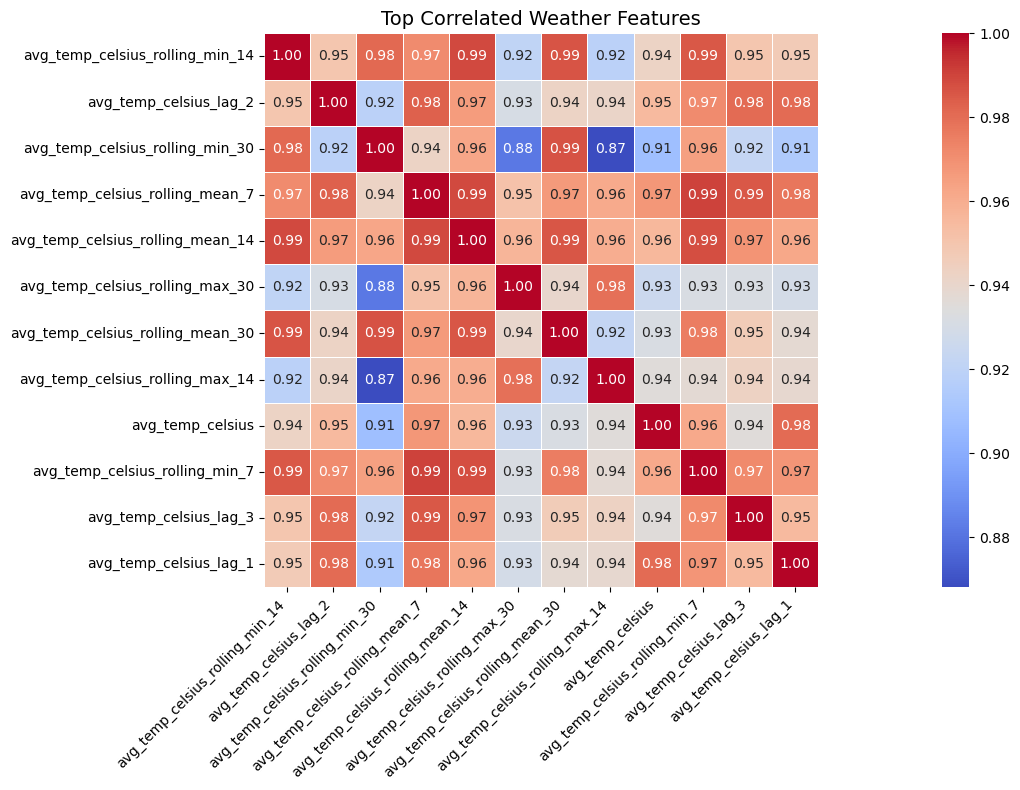

Feature 1,Feature 2,Correlation
avg_temp_celsius_rolling_mean_7,avg_temp_celsius_rolling_min_7,0.9907
avg_temp_celsius_rolling_mean_7,avg_temp_celsius_rolling_mean_14,0.9890
avg_temp_celsius_rolling_min_14,avg_temp_celsius_rolling_mean_14,0.9889
avg_temp_celsius_rolling_min_7,avg_temp_celsius_rolling_mean_14,0.9878
avg_temp_celsius_rolling_mean_30,avg_temp_celsius_rolling_min_30,0.9868
avg_temp_celsius_rolling_min_14,avg_temp_celsius_rolling_mean_30,0.9865
avg_temp_celsius_rolling_mean_30,avg_temp_celsius_rolling_mean_14,0.9859
avg_temp_celsius_rolling_min_14,avg_temp_celsius_rolling_min_7,0.9853
avg_temp_celsius_rolling_mean_7,avg_temp_celsius_lag_3,0.9852
avg_temp_celsius_lag_2,avg_temp_celsius_rolling_mean_7,0.9834


In [11]:
df = pd.read_csv("../data/saved/processed_weather_features.csv", parse_dates=['date'], index_col='date')

# Get the actual top correlated pairs (non-styled)
def extract_top_correlations_df(corr_matrix, top_n=15):
    corr_pairs = corr_matrix.abs().unstack()
    corr_pairs = corr_pairs[corr_pairs < 1.0]
    top_pairs  = corr_pairs.sort_values(ascending=False).drop_duplicates().head(top_n)
    
    # Return as clean DataFrame (not styled)
    return (
        top_pairs
        .reset_index()
        .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
        .round(4)
    )

corr_matrix   = df.corr(numeric_only=True)

# 1. Get raw correlations
top_corr_df = extract_top_correlations_df(corr_matrix)

# 2. Extract unique variables involved in top correlations
top_vars = list(set(top_corr_df['Feature 1'].tolist() + top_corr_df['Feature 2'].tolist()))

# 3. Filter matrix for heatmap
filtered_corr = corr_matrix.loc[top_vars, top_vars]

# 4. Display styled version (optional)
styled_corr = top_corr_df.style.hide(axis='index').format({'Correlation': '{:.4f}'})

# 5. Plot heatmap
plt.figure(figsize=(25, 8))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5, cbar=True)
plt.title("Top Correlated Weather Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

display(styled_corr)

In [12]:
def get_feature_importance_with_correlation(df, target_col, top_n=15, plot=True):
    # Data preparation
    df = df.dropna(subset=[target_col])
    X  = df.drop(columns=[target_col]).select_dtypes(include=[np.number])
    y  = df[target_col]
    
    # Handle missing values
    imputer   = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    
    # Random Forest feature importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_imputed, y)
    
    feature_importances = pd.DataFrame({
        'Feature': X_imputed.columns,
        'RF_Importance': rf.feature_importances_
    }).sort_values(by='RF_Importance', ascending=False)
    
    # Correlation with target
    correlations = df.corr(numeric_only=True)[target_col].drop(target_col, errors='ignore').abs().reset_index()
    correlations.columns = ['Feature', 'Correlation']
    
    # Combine results
    combined = pd.merge(feature_importances, correlations, on='Feature')
    combined['Average_Score'] = combined[['RF_Importance', 'Correlation']].mean(axis=1)
    combined = combined.sort_values(by='Average_Score', ascending=False).round(4)
    
    # Display results
    print(f"📊 Top {top_n} Features by Combined Importance (RF + Correlation) for target '{target_col}':")
    display(combined.head(top_n))
    
    # Visualization
    if plot:
        plt.figure(figsize=(12, 6))
        sns.barplot(data=combined.head(top_n), x='Average_Score', y='Feature', palette='viridis')
        plt.title(f"Top {top_n} Features by Combined Importance (RF + Correlation)\nTarget: {target_col}", fontsize=14)
        plt.xlabel("Average Importance Score")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    
    return combined

📊 Top 15 Features by Combined Importance (RF + Correlation) for target 'avg_temp_celsius':


,Feature,RF_Importance,Correlation,Average_Score
0,avg_temp_celsius_lag_1,0.3722,0.9807,0.6765
1,max_temp_celsius,0.2699,0.9770,0.6235
2,avg_temp_celsius_rolling_mean_7,0.1617,0.9678,0.5648
3,min_temp_celsius,0.1431,0.9712,0.5572
4,avg_temp_celsius_rolling_min_7,0.0255,0.9614,0.4934
5,avg_temp_celsius_rolling_max_7,0.0182,0.9482,0.4832
6,avg_temp_celsius_rolling_mean_14,0.0011,0.9561,0.4786
17,avg_temp_celsius_lag_2,0.0003,0.9548,0.4776
8,avg_temp_celsius_rolling_min_14,0.0007,0.9426,0.4716
13,avg_temp_celsius_lag_3,0.0004,0.9356,0.4680


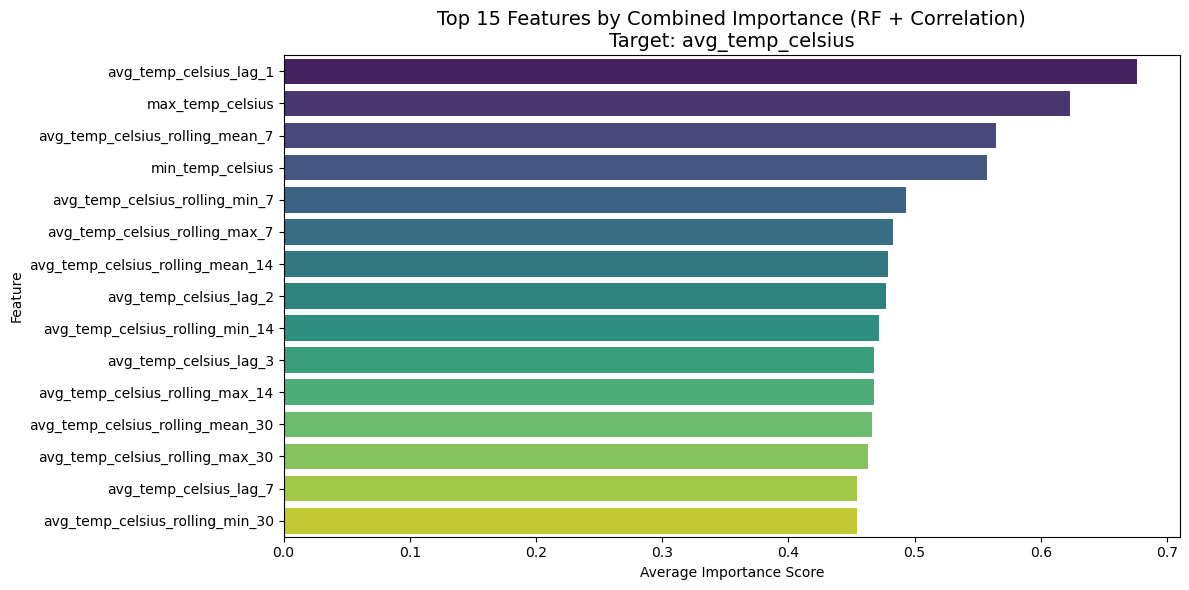

In [13]:
feature_import_reg_df = get_feature_importance_with_correlation(df, target_col=target_col_reg)

📊 Top 15 Features by Combined Importance (RF + Correlation) for target 'rain_label':


,Feature,RF_Importance,Correlation,Average_Score
0,rain_total_mm,1.0,0.4160,0.7080
23,total_precip_mm,0.0,0.3459,0.1730
24,precip_hours,0.0,0.3435,0.1717
13,temp_range,0.0,0.2897,0.1449
1,max_temp_celsius,0.0,0.2340,0.1170
22,avg_temp_celsius,0.0,0.1921,0.0961
11,avg_temp_celsius_rolling_max_14,0.0,0.1723,0.0861
5,avg_temp_celsius_rolling_max_30,0.0,0.1713,0.0856
27,avg_temp_celsius_lag_1,0.0,0.1641,0.0820
34,avg_temp_celsius_rolling_min_7,0.0,0.1640,0.0820


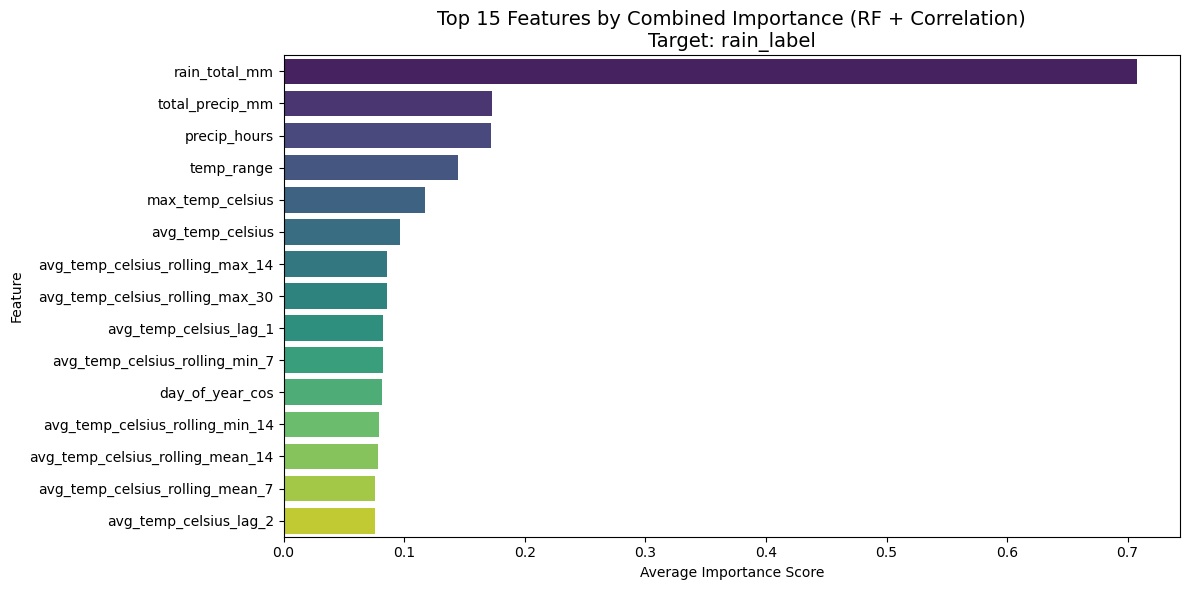

In [14]:
feature_import_clf_df = get_feature_importance_with_correlation(df, target_col=target_col_clf)

In [15]:
selected_features_reg = [
    'avg_temp_celsius_lag_1',
    'max_temp_celsius',
    'avg_temp_celsius_rolling_mean_7',
    'min_temp_celsius',
    'avg_temp_celsius_rolling_min_7',
    'avg_temp_celsius_rolling_max_7',
    'avg_temp_celsius_rolling_mean_14',
    'avg_temp_celsius_lag_2',
    'avg_temp_celsius_rolling_min_14',
    'avg_temp_celsius_lag_3',
    'avg_temp_celsius_rolling_max_14',
    'avg_temp_celsius_rolling_mean_30',
    'avg_temp_celsius_rolling_max_30',
    'avg_temp_celsius_lag_7',
    'avg_temp_celsius_rolling_min_30',
]

df_lstm_reg = df[selected_features_reg + [target_col_reg]].dropna().reset_index(drop=True)
df_lstm_reg.head()

,avg_temp_celsius_lag_1,max_temp_celsius,avg_temp_celsius_rolling_mean_7,min_temp_celsius,avg_temp_celsius_rolling_min_7,avg_temp_celsius_rolling_max_7,avg_temp_celsius_rolling_mean_14,avg_temp_celsius_lag_2,avg_temp_celsius_rolling_min_14,avg_temp_celsius_lag_3,avg_temp_celsius_rolling_max_14,avg_temp_celsius_rolling_mean_30,avg_temp_celsius_rolling_max_30,avg_temp_celsius_lag_7,avg_temp_celsius_rolling_min_30,avg_temp_celsius
0,31.4,41.0,28.771429,23.0,26.7,31.4,28.357143,30.5,26.3,28.3,31.4,28.373333,31.4,27.8,26.3,30.5
1,30.5,36.6,28.942857,21.9,26.7,31.4,28.442857,31.4,26.3,30.5,31.4,28.356250,31.4,26.9,26.3,28.1
2,28.1,34.8,28.957143,19.8,26.8,31.4,28.478571,30.5,26.7,31.4,31.4,28.264706,31.4,26.7,26.3,26.8
3,26.8,35.2,29.000000,21.9,26.8,31.4,28.514286,28.1,26.7,30.5,31.4,28.216667,31.4,27.1,26.3,27.4
4,27.4,36.1,28.942857,22.0,26.8,31.4,28.485714,26.8,26.7,28.1,31.4,28.200000,31.4,28.3,26.3,27.9


In [16]:
selected_features_cls = [
    'rain_total_mm',
    'total_precip_mm',
    'precip_hours',
    'temp_range',
    'max_temp_celsius',
    'avg_temp_celsius',
    'avg_temp_celsius_rolling_max_14',
    'avg_temp_celsius_rolling_max_30',
    'avg_temp_celsius_lag_1',
    'avg_temp_celsius_rolling_min_7',
    'day_of_year_cos',
    'avg_temp_celsius_rolling_min_14',
    'avg_temp_celsius_rolling_mean_14',
    'avg_temp_celsius_rolling_mean_7',
    'avg_temp_celsius_lag_2',
]

df_lstm_clf = df[selected_features_cls + [target_col_clf]].dropna().reset_index(drop=True)
df_lstm_clf.head()

,rain_total_mm,total_precip_mm,precip_hours,temp_range,max_temp_celsius,avg_temp_celsius,avg_temp_celsius_rolling_max_14,avg_temp_celsius_rolling_max_30,avg_temp_celsius_lag_1,avg_temp_celsius_rolling_min_7,day_of_year_cos,avg_temp_celsius_rolling_min_14,avg_temp_celsius_rolling_mean_14,avg_temp_celsius_rolling_mean_7,avg_temp_celsius_lag_2,rain_label
0,0.0,0.0,0.0,18.0,41.0,30.5,31.4,31.4,31.4,26.7,-0.964094,26.3,28.357143,28.771429,30.5,0
1,0.0,0.0,0.0,14.7,36.6,28.1,31.4,31.4,30.5,26.7,-0.968519,26.3,28.442857,28.942857,31.4,0
2,0.0,0.0,0.0,15.0,34.8,26.8,31.4,31.4,28.1,26.8,-0.972658,26.7,28.478571,28.957143,30.5,0
3,0.0,0.0,0.0,13.3,35.2,27.4,31.4,31.4,26.8,26.8,-0.976509,26.7,28.514286,29.000000,28.1,0
4,0.0,0.0,0.0,14.1,36.1,27.9,31.4,31.4,27.4,26.8,-0.980071,26.7,28.485714,28.942857,26.8,0


In [17]:
def show_missing(df, name=""):
    print(f"Missing values in {name}:")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    print(missing)
    print("-" * 50)

show_missing(df_lstm_reg, "Regression Dataset")
show_missing(df_lstm_clf, "Classification Dataset")

Missing values in Regression Dataset:
Series([], dtype: int64)
--------------------------------------------------
Missing values in Classification Dataset:
Series([], dtype: int64)
--------------------------------------------------


In [18]:
def prepare_features(df, target_col):
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame")
    
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Select only numeric features
    X = X.select_dtypes(include=['number'])
    
    # Apply MinMax scaling
    scaler   = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    return X_scaled, y

In [19]:
X_reg_scaled, y_reg = prepare_features(df_lstm_reg, target_col=target_col_reg)
X_reg_scaled.head()

,avg_temp_celsius_lag_1,max_temp_celsius,avg_temp_celsius_rolling_mean_7,min_temp_celsius,avg_temp_celsius_rolling_min_7,avg_temp_celsius_rolling_max_7,avg_temp_celsius_rolling_mean_14,avg_temp_celsius_lag_2,avg_temp_celsius_rolling_min_14,avg_temp_celsius_lag_3,avg_temp_celsius_rolling_max_14,avg_temp_celsius_rolling_mean_30,avg_temp_celsius_rolling_max_30,avg_temp_celsius_lag_7,avg_temp_celsius_rolling_min_30
0,1.000000,0.988764,0.962529,0.933673,0.883598,1.0,0.956152,0.957944,0.885870,0.855140,1.0,0.975177,1.0,0.831776,0.936782
1,0.957944,0.823970,0.971897,0.877551,0.883598,1.0,0.961260,1.000000,0.885870,0.957944,1.0,0.974108,1.0,0.789720,0.936782
2,0.845794,0.756554,0.972678,0.770408,0.888889,1.0,0.963389,0.957944,0.907609,1.000000,1.0,0.968380,1.0,0.780374,0.936782
3,0.785047,0.771536,0.975020,0.877551,0.888889,1.0,0.965517,0.845794,0.907609,0.957944,1.0,0.965373,1.0,0.799065,0.936782
4,0.813084,0.805243,0.971897,0.882653,0.888889,1.0,0.963814,0.785047,0.907609,0.845794,1.0,0.964330,1.0,0.855140,0.936782


In [20]:
X_clf_scaled, y_clf = prepare_features(df_lstm_clf, target_col=target_col_clf)
X_clf_scaled.head()

,rain_total_mm,total_precip_mm,precip_hours,temp_range,max_temp_celsius,avg_temp_celsius,avg_temp_celsius_rolling_max_14,avg_temp_celsius_rolling_max_30,avg_temp_celsius_lag_1,avg_temp_celsius_rolling_min_7,day_of_year_cos,avg_temp_celsius_rolling_min_14,avg_temp_celsius_rolling_mean_14,avg_temp_celsius_rolling_mean_7,avg_temp_celsius_lag_2
0,0.0,0.0,0.0,0.776536,0.988764,1.000000,1.0,1.0,1.000000,0.883598,0.017943,0.885870,0.956152,0.962529,0.957944
1,0.0,0.0,0.0,0.592179,0.823970,0.882927,1.0,1.0,0.957944,0.883598,0.015730,0.885870,0.961260,0.971897,1.000000
2,0.0,0.0,0.0,0.608939,0.756554,0.819512,1.0,1.0,0.845794,0.888889,0.013661,0.907609,0.963389,0.972678,0.957944
3,0.0,0.0,0.0,0.513966,0.771536,0.848780,1.0,1.0,0.785047,0.888889,0.011735,0.907609,0.965517,0.975020,0.845794
4,0.0,0.0,0.0,0.558659,0.805243,0.873171,1.0,1.0,0.813084,0.888889,0.009954,0.907609,0.963814,0.971897,0.785047


In [21]:
def train_test_split_data(X, y, test_size=0.2):
    # Input validation
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    if not 0 < test_size < 1:
        raise ValueError("test_size must be between 0 and 1")
    
    # Time-based split
    split_index = int(len(X) * (1 - test_size))
    
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    print(f"Training set size : {X_train.shape} , {y_train.shape}")
    print(f"Testing  set size : {X_test.shape}  , {y_test.shape}")
    return X_train, X_test, y_train, y_test


In [22]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split_data(X_reg_scaled,y_reg,test_size=0.2)

Training set size : (304, 15) , (304,)
Testing  set size : (77, 15)  , (77,)


In [23]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split_data(X_clf_scaled,y_clf,test_size=0.2)

Training set size : (304, 15) , (304,)
Testing  set size : (77, 15)  , (77,)


In [24]:
# Transform data into sequences for LSTM input.
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X.iloc[i:i+sequence_length].values)
        y_seq.append(y.iloc[i+sequence_length])
    return np.array(X_seq), np.array(y_seq)

In [25]:
sequence_length = 7

X_train_seq_reg, y_train_seq_reg = create_sequences(X_train_reg, y_train_reg, sequence_length)
X_test_seq_reg,  y_test_seq_reg  = create_sequences(X_test_reg,  y_test_reg,  sequence_length)

print("X_train_seq_reg.shape :", X_train_seq_reg.shape)
print("y_train_seq_reg.shape :", y_train_seq_reg.shape)
print("X_test_seq_reg.shape  :", X_test_seq_reg.shape)
print("y_test_seq_reg.shape  :", y_test_seq_reg.shape)

X_train_seq_reg.shape : (297, 7, 15)
y_train_seq_reg.shape : (297,)
X_test_seq_reg.shape  : (70, 7, 15)
y_test_seq_reg.shape  : (70,)


In [26]:
X_train_seq_clf, y_train_seq_clf = create_sequences(X_train_clf, y_train_clf, sequence_length)
X_test_seq_clf,  y_test_seq_clf  = create_sequences(X_test_clf,  y_test_clf,  sequence_length)

print("X_train_seq_clf.shape :", X_train_seq_clf.shape)
print("y_train_seq_clf.shape :", y_train_seq_clf.shape)
print("X_test_seq_clf.shape  :", X_test_seq_clf.shape)
print("y_test_seq_clf.shape  :", y_test_seq_clf.shape)

X_train_seq_clf.shape : (297, 7, 15)
y_train_seq_clf.shape : (297,)
X_test_seq_clf.shape  : (70, 7, 15)
y_test_seq_clf.shape  : (70,)
